### Load the Data from INSPIRE Labs

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import ast
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.nan)
pd.options.display.max_colwidth = 1000

In [2]:
%%time

# Read the records
records = pd.read_csv('new-citations.tsv', sep='\t', header=None)
records.columns = ['recID', 'oldRef', 'newRef', 'metaData']

print('Total Records: {}'.format(len(records)))

Total Records: 30230224
CPU times: user 2min 31s, sys: 7.84 s, total: 2min 39s
Wall time: 2min 40s


### Load the legacy citation counts and compare against the new ones

In [5]:
# Read the records
legacy_records = pd.read_csv('old-citation-counts.tsv', sep='\t')
legacy_records.columns = ['recID', 'citation_count']
legacy_records = legacy_records.set_index('recID')

In [6]:
# Order the legacy number of citations by citation count
legacy = legacy_records.citation_count.sort_values(ascending=False)

In [7]:
# Get the citation counts as per the new Labs algorithms
labs = records.newRef.value_counts()
labs = labs[1:] # Ignore the records with recID == 0

In [8]:
# Calculate the difference between the two
diff2 = labs - legacy

# Extract the valid values from the difference i.e. != NaN
diff2 = diff2.valid()

In [10]:
# Indicate Number of articles with zero differences in citation counts
num_cited_legacy = len(legacy.index.unique())
num_cited_labs = len(labs.index.unique())
num_unique_articles = len(records.recID.unique())
print('Total number of unique Cited articles as per legacy: {}'.format(num_cited_legacy))
print('Total number of unique Cited articles as per Labs: {}'.format(num_cited_labs))
print('Difference in Number between the Legacy and Labs Records: {}'.format(num_cited_legacy - num_cited_labs))
print('\nTotal Number of Unique Articles which cite other papers: {}\n'.format(num_unique_articles))

num_zero_diff = diff2.value_counts()[0]
zero_diff = num_zero_diff / num_cited_legacy * 100
print('Number of Cited articles with zero difference: {}'.format(num_zero_diff))
print('Percentage of Cited articles with zero difference: {0:0.2f} %'.format(zero_diff))

Total number of unique Cited articles as per legacy: 760203
Total number of unique Cited articles as per Labs: 759481
Difference in Number between the Legacy and Labs Records: 722

Total Number of Unique Articles which cite other papers: 942155

Number of Cited articles with zero difference: 652046
Percentage of Cited articles with zero difference: 85.77 %


([<matplotlib.axis.XTick at 0x7fd115728320>,
 <a list of 13 Text xticklabel objects>)

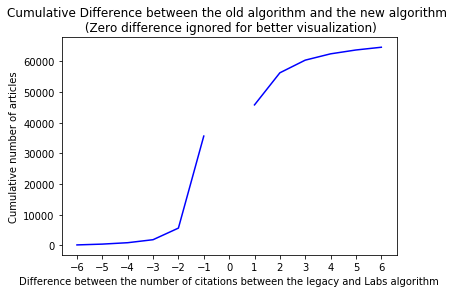

In [11]:
# Draw a cumulative distribution plot
%matplotlib inline
cumulative = np.cumsum(diff2.value_counts().sort_index()[-6:-1]) #Ignore the articles with ID 0 because they are unlinked
cumulative2 = np.cumsum(diff2.value_counts().sort_index()[1:6])
plt.plot(cumulative, c='blue')
plt.plot(cumulative2, c='blue')
plt.title('Cumulative Difference between the old algorithm and the new algorithm \n (Zero difference ignored for better visualization)')
plt.ylabel('Cumulative number of articles')
plt.xlabel('Difference between the number of citations between the legacy and Labs algorithm')
plt.xticks(np.arange(-6, 7, 1.0))

Text(0.5,0,'Difference between the number of citations between the legacy and Labs algorithm')

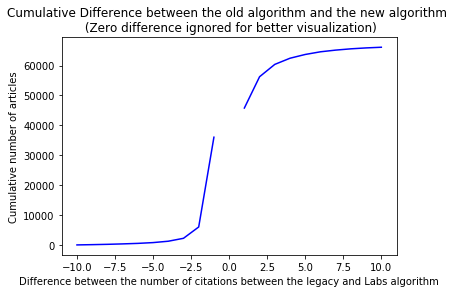

In [12]:
# Draw a cumulative distribution plot
%matplotlib inline
cumulative = np.cumsum(diff2.value_counts().sort_index()[-10:-1]) #Ignore the articles with ID 0 because they are unlinked
cumulative2 = np.cumsum(diff2.value_counts().sort_index()[1:10])
plt.plot(cumulative, c='blue')
plt.plot(cumulative2, c='blue')
plt.title('Cumulative Difference between the old algorithm and the new algorithm \n (Zero difference ignored for better visualization)')
plt.ylabel('Cumulative number of articles')
plt.xlabel('Difference between the number of citations between the legacy and Labs algorithm')

Text(0.5,0,'Difference between the number of citations between the legacy and Labs algorithm')

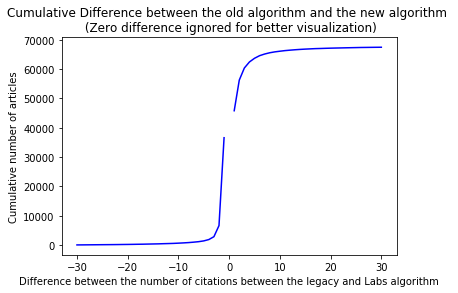

In [13]:
# Draw a cumulative distribution plot
%matplotlib inline
cumulative = np.cumsum(diff2.value_counts().sort_index()[-30:-1]) #Ignore the articles with ID 0 because they are unlinked
cumulative2 = np.cumsum(diff2.value_counts().sort_index()[1:30])
plt.plot(cumulative, c='blue')
plt.plot(cumulative2, c='blue')
plt.title('Cumulative Difference between the old algorithm and the new algorithm \n (Zero difference ignored for better visualization)')
plt.ylabel('Cumulative number of articles')
plt.xlabel('Difference between the number of citations between the legacy and Labs algorithm')

([<matplotlib.axis.XTick at 0x7fd11569c668>,
 <a list of 13 Text xticklabel objects>)

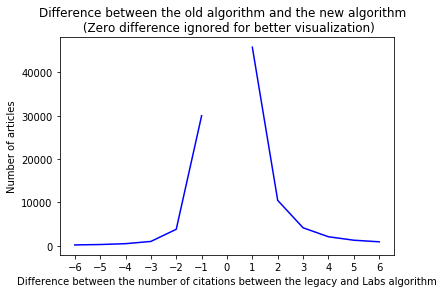

In [14]:
# Plot the results which show the occurenc of the frequency of the citation differences
%matplotlib inline
cumulative = diff2.value_counts().sort_index()[-6:-1] #Ignore the articles with ID 0 because they are unlinked
cumulative2 = diff2.value_counts().sort_index()[1:6]
plt.plot(cumulative, c='blue')
plt.plot(cumulative2, c='blue')
plt.title('Difference between the old algorithm and the new algorithm  \n (Zero difference ignored for better visualization)')
plt.ylabel('Number of articles')
plt.xlabel('Difference between the number of citations between the legacy and Labs algorithm')
plt.xticks(np.arange(-6, 7, 1.0))

Text(0.5,0,'Difference between the number of citations between the legacy and Labs algorithm')

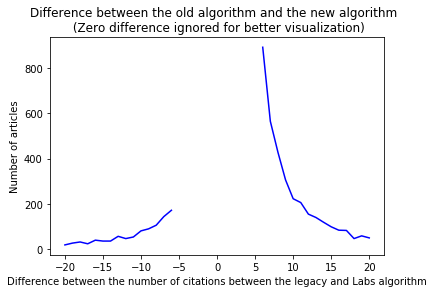

In [15]:
# Plot the results which show the occurenc of the frequency of the citation differences
%matplotlib inline
cumulative = diff2.value_counts().sort_index()[-20:-6] #Ignore the articles with ID 0 because they are unlinked
cumulative2 = diff2.value_counts().sort_index()[6:20]
plt.plot(cumulative, c='blue')
plt.plot(cumulative2, c='blue')
plt.title('Difference between the old algorithm and the new algorithm  \n (Zero difference ignored for better visualization)')
plt.ylabel('Number of articles')
plt.xlabel('Difference between the number of citations between the legacy and Labs algorithm')

Text(0.5,0,'Difference between the number of citations between the legacy and Labs algorithm')

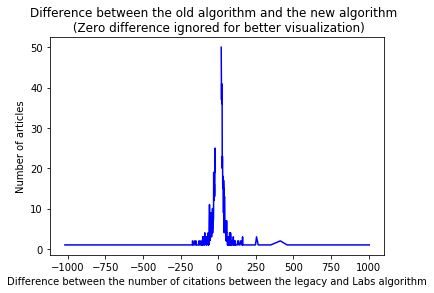

In [16]:
# Plot the results which show the occurenc of the frequency of the citation differences
%matplotlib inline
cumulative = diff2.value_counts().sort_index()[:-20] #Ignore the articles with ID 0 because they are unlinked
cumulative2 = diff2.value_counts().sort_index()[20:]
plt.plot(cumulative, c='blue')
plt.plot(cumulative2, c='blue')
plt.title('Difference between the old algorithm and the new algorithm  \n (Zero difference ignored for better visualization)')
plt.ylabel('Number of articles')
plt.xlabel('Difference between the number of citations between the legacy and Labs algorithm')

In [17]:
%%time
# Get the articles which have lost citations
lost = diff2 < 0
lost_citations = diff2[lost]
print('Total {} articles lost citations in the Labs algorithm, with maximum lost count being {}'.format(
    len(lost_citations), lost_citations.min()))

Total 36923 articles lost citations in the Labs algorithm, with maximum lost count being -1020.0
CPU times: user 16.2 s, sys: 276 µs, total: 16.2 s
Wall time: 16.2 s


In [18]:
%%time
# Get the articles which have gained citations
gained = diff2 > 0
gained_citations = diff2[gained]
print('Total {} articles gained citations in the Labs algorithm, with maximum gained count being {}'.format(
    len(gained_citations), gained_citations.max()))

Total 67857 articles gained citations in the Labs algorithm, with maximum gained count being 1005.0
CPU times: user 16.7 s, sys: 4.19 ms, total: 16.7 s
Wall time: 16.7 s


In [19]:
# Get the ordered lists

# Get the combined list
sorted_overall = pd.DataFrame(diff2.sort_values())
sorted_overall.columns = ['Citation_Difference']

# Get the list for lost citations
sorted_lost = pd.DataFrame(lost_citations.sort_values(ascending=True))
sorted_lost.columns = ['Citation_Difference']

# Get the list for gained citations
sorted_gained = pd.DataFrame(gained_citations.sort_values(ascending=False))
sorted_gained.columns = ['Citation_Difference']

In [20]:
# Export all the ordered lists to CSV
sorted_overall.to_csv('Citation Differences/complete_list.csv')
sorted_lost.to_csv('Citation Differences/lost_citations_list.csv')
sorted_gained.to_csv('Citation Differences/gained_citations_list.csv')

#### Further Statistics about percentage differences in citation counts

In [21]:
# Calculate the absolute differences
abs_diff = np.abs(labs - legacy)
# Count values for the absoulte differences
abs_diff_counts = abs_diff.value_counts()

In [22]:
# Percentage Differences for absolute differences
print('Percent (%) of Citation Counts Difference in Labs')
print(abs_diff_counts[:5] / num_cited_legacy * 100)

num_grt5 = sum(abs_diff_counts[6:])
percent_grt5 = num_grt5 / num_cited_legacy * 100
print('\nTotal {} records with difference greater than 5 - Percentage: {} %\n'.format(num_grt5, percent_grt5))

Percent (%) of Citation Counts Difference in Labs
0.0    85.772616
1.0     9.971416
2.0     1.873184
3.0     0.671268
4.0     0.330833
5.0     0.199815
dtype: float64

Total 5600 records with difference greater than 5 - Percentage: 0.736645343414851 %



In [25]:
# Percentage Differences for lost citations
lost_citations_count = lost_citations.value_counts()
lost_percent_diff = lost_citations_count/ num_cited_legacy * 100
print('Percent (%) of Citation Counts Lost in Labs')
print(lost_percent_diff[:-5])

lost_grt5 = sum(lost_citations_count[-6:])
lost_percent_grt5 = lost_grt5 / num_cited_legacy * 100
print('\nTotal {} records with lost citations greater than 5 - Percentage: {} %\n'.format(lost_grt5, lost_percent_grt5))

Percent (%) of Citation Counts Lost in Labs
-1.0    3.945262
-2.0    0.497630
-3.0    0.128518
-4.0    0.060247
-5.0    0.034596
dtype: float64

Total 1450 records with lost citations greater than 5 - Percentage: 0.1907385264199168 %



In [26]:
# Percentage Differences for gained citations
gained_citations_count = gained_citations.value_counts()
gained_percent_diff = gained_citations_count/ num_cited_legacy * 100
print('Percent (%) of Citation Counts Gained in Labs')
print(gained_percent_diff[:5])

gained_grt5 = sum(gained_citations_count[6:])
gained_percent_grt5 = gained_grt5 / num_cited_legacy * 100
print('\nTotal {} records with gained citations greater than 5 - Percentage: {} %\n'.format(gained_grt5, gained_percent_grt5))

Percent (%) of Citation Counts Gained in Labs
1.0    6.026154
2.0    1.375554
3.0    0.542750
4.0    0.270586
5.0    0.165219
dtype: float64

Total 4150 records with gained citations greater than 5 - Percentage: 0.5459068169949343 %

